## 1. Configuración del programa
En esta celda se importan las librerías necesarias y se define la configuración global para la ejecución del programa. Aquí se fija el dispositivo de ejecución (CPU o GPU), el número de ejemplos a generar, los hiperparámetros principales del modelo y la ruta donde se guardarán los datos y los modelos entrenados.

In [1]:
import os
import math
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import TranslationDataset, collate_fn, Vocab
from model import Encoder, Decoder, Seq2Seq
from data.dataGenerator import generate_data

# Dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)

# Rutas y configuración
DATA_PATH = "data/es-en.txt"  
N_SAMPLES = 2500              
MIN_FREQ = 1                  
BATCH_SIZE = 64
EPOCHS = 15
LR = 5e-4
CLIP = 1.0
TEACHER_FORCING = 0.6

# Parámetros del modelo
EMB_DIM = 64
ENC_HID_DIM = 128
DEC_HID_DIM = 128
ATTN_DIM = 64

# Inferencia
MAX_LEN = 30
DIRECTION = "es-en"
MODEL_PATH = f"seq2seq_bahdanau_{DIRECTION}.pt"


DEVICE = cpu


## 2. Generación del Dataset
Esta celda se genera el dataset español–inglés. Se crean frases simples y sus traducciones, y se guardan en un archivo es-en.txt con el formato requerido es ||| en.

In [2]:
generate_data(n=N_SAMPLES, out_path='data/es-en.txt')

print("Dataset generado en:", DATA_PATH)

with open(DATA_PATH, "r", encoding="utf-8") as f:
    for i in range(5):
        print(f.readline().strip())

Wrote 2500 pairs to data\es-en.txt
Dataset generado en: data/es-en.txt
hoy yo leo ||| today i read
yo leo en la ciudad ||| i read in the city
el estudiante está grande en la ciudad ||| the student is big in the city
ahora la casa está cansado ||| now the house is tired
ahora yo está listo ||| now i is smart


## 3. Función para entrenar la red
En esta celda se define una función que construye lo necesario para entrenar una dirección concreta (es-en o en-es): el dataset con sus dos vocabularios, dataloader con padding, el modelo seq2seq con LSTM y atención de Bahdanau, la función de pérdida ignorando pad, y el optimizador. 

In [3]:
def build_training_stack(direction: str):
    dataset = TranslationDataset(DATA_PATH, direction=direction, min_freq=MIN_FREQ)

    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=lambda b: collate_fn(
            b,
            src_pad_value=dataset.src_pad_idx,
            trg_pad_value=dataset.trg_pad_idx,
        ),
    )

    encoder = Encoder(
        vocab_size=len(dataset.src_vocab.itos),
        emb_dim=EMB_DIM,
        hid_dim=ENC_HID_DIM,
        n_layers=1,
        dropout=0.1,
        bidir=True,
        pad_idx=dataset.src_pad_idx,
    )

    decoder = Decoder(
        vocab_size=len(dataset.trg_vocab.itos),
        emb_dim=EMB_DIM,
        enc_hid_dim=ENC_HID_DIM * 2,  # bidir => x2
        dec_hid_dim=DEC_HID_DIM,
        attn_dim=ATTN_DIM,
        dropout=0.1,
        pad_idx=dataset.trg_pad_idx,
    )

    model = Seq2Seq(
        encoder=encoder,
        decoder=decoder,
        sos_idx=dataset.trg_sos_idx,
        eos_idx=dataset.trg_eos_idx,
        device=DEVICE,
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=dataset.trg_pad_idx)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    return dataset, loader, model, criterion, optimizer


## 4. Bucle de entrenamiento
En esta celda se define el bucle de entrenamiento de una época: para cada batch se ejecuta el forward del modelo con teacher forcing, se calcula la pérdida ignorando el token sos (comenzamos desde t=1), se hace backpropagation, se aplica clipping de gradiente para estabilidad y se actualizan los pesos con el optimizador. Devuelve la loss media para monitorizar el aprendizaje.

In [4]:
def train_one_epoch(model, loader, criterion, optimizer, teacher_forcing_ratio: float):
    model.train()
    total_loss = 0.0

    for batch in loader:
        src = batch.src.to(DEVICE)
        trg = batch.trg.to(DEVICE)
        src_mask = batch.src_mask.to(DEVICE)
        src_lens = batch.src_lens.to(DEVICE)

        optimizer.zero_grad()

        outputs, _attn = model(
            src=src,
            trg=trg,
            src_lengths=src_lens,
            mask=src_mask,
            teacher_forcing_ratio=teacher_forcing_ratio,
        )

        # outputs: [B, Ty, V]
        # trg:     [B, Ty]
        # Ignoramos la posición 0 (donde está <sos>) en la loss
        out_dim = outputs.shape[-1]
        loss = criterion(
            outputs[:, 1:, :].reshape(-1, out_dim),
            trg[:, 1:].reshape(-1),
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / max(1, len(loader))


## 5. Entrenamiento y guardado del modelo
En esta celda se entrena y se guarda un modelo para una dirección concreta. Al finalizar, se guarda un checkpoint .pt que incluye: pesos del modelo, configuración, vocabularios (itos) y los índices especiales (pad, sos, eos). Esto permite que se pueda reconstruir el modelo en inferencia sin depender del dataset en memoria.

In [5]:
def train_and_save(direction: str, epochs: int = EPOCHS):
    dataset, loader, model, criterion, optimizer = build_training_stack(direction)

    print(f"\n=== Entrenando dirección: {direction} ===")
    print("SRC vocab size:", len(dataset.src_vocab.itos))
    print("TRG vocab size:", len(dataset.trg_vocab.itos))

    best_loss = float("inf")

    for epoch in range(1, epochs + 1):
        # Teacher forcing opcionalmente podría decaer; lo dejamos fijo por simplicidad
        loss = train_one_epoch(model, loader, criterion, optimizer, TEACHER_FORCING)

        print(f"{direction} | Epoch {epoch:02d}/{epochs} | Loss: {loss:.4f}")

        if loss < best_loss:
            best_loss = loss

            ckpt = {
                "direction": direction,
                "model_state_dict": model.state_dict(),
                "config": {
                    "emb_dim": EMB_DIM,
                    "enc_hid_dim": ENC_HID_DIM,
                    "dec_hid_dim": DEC_HID_DIM,
                    "attn_dim": ATTN_DIM,
                    "bidir": True,
                },
                "vocabs": {
                    "src_itos": dataset.src_vocab.itos,
                    "trg_itos": dataset.trg_vocab.itos,
                },
                "special": {
                    "src_pad_idx": dataset.src_pad_idx,
                    "trg_pad_idx": dataset.trg_pad_idx,
                    "trg_sos_idx": dataset.trg_sos_idx,
                    "trg_eos_idx": dataset.trg_eos_idx,
                },
            }

            out_path = f"seq2seq_bahdanau_{direction}.pt"
            torch.save(ckpt, out_path)

    print(f"✅ Guardado mejor modelo ({direction}) con loss {best_loss:.4f} en seq2seq_bahdanau_{direction}.pt")


## 6. Entrenamiento Bidireccional
En esta celda se ejecuta el entrenamiento bidireccional completo: primero entrenamos el modelo es-en y luego el modelo en-es. Esto produce dos checkpoints independientes, uno por dirección, que se cargarán después para inferencia en la dirección deseada.

In [6]:
train_and_save("es-en", epochs=EPOCHS)
train_and_save("en-es", epochs=EPOCHS)

print("\nCheckpoints generados:")
for p in ["seq2seq_bahdanau_es-en.pt", "seq2seq_bahdanau_en-es.pt"]:
    print("-", p, "=>", "OK" if Path(p).exists() else "NO EXISTE")



=== Entrenando dirección: es-en ===
SRC vocab size: 54
TRG vocab size: 55
es-en | Epoch 01/15 | Loss: 3.4700
es-en | Epoch 02/15 | Loss: 2.4183
es-en | Epoch 03/15 | Loss: 1.3416
es-en | Epoch 04/15 | Loss: 0.6036
es-en | Epoch 05/15 | Loss: 0.2383
es-en | Epoch 06/15 | Loss: 0.1014
es-en | Epoch 07/15 | Loss: 0.0547
es-en | Epoch 08/15 | Loss: 0.0354
es-en | Epoch 09/15 | Loss: 0.0249
es-en | Epoch 10/15 | Loss: 0.0188
es-en | Epoch 11/15 | Loss: 0.0148
es-en | Epoch 12/15 | Loss: 0.0121
es-en | Epoch 13/15 | Loss: 0.0099
es-en | Epoch 14/15 | Loss: 0.0084
es-en | Epoch 15/15 | Loss: 0.0072
✅ Guardado mejor modelo (es-en) con loss 0.0072 en seq2seq_bahdanau_es-en.pt

=== Entrenando dirección: en-es ===
SRC vocab size: 55
TRG vocab size: 54
en-es | Epoch 01/15 | Loss: 3.4712
en-es | Epoch 02/15 | Loss: 2.4369
en-es | Epoch 03/15 | Loss: 1.3988
en-es | Epoch 04/15 | Loss: 0.5533
en-es | Epoch 05/15 | Loss: 0.1766
en-es | Epoch 06/15 | Loss: 0.0758
en-es | Epoch 07/15 | Loss: 0.0435
en-

## 7. Cargar Modelo
En esta celda se define una función para cargar un checkpoint y reconstruir el modelo exactamente con la misma arquitectura usada en entrenamiento. Se reconstruyen además los vocabularios desde itos guardado, y se recuperan los índices especiales.

In [7]:
def load_checkpoint(model_path: str):
    ckpt = torch.load(model_path, map_location=DEVICE)

    cfg = ckpt["config"]
    src_vocab = Vocab.from_itos(ckpt["vocabs"]["src_itos"])
    trg_vocab = Vocab.from_itos(ckpt["vocabs"]["trg_itos"])

    src_pad_idx = ckpt["special"]["src_pad_idx"]
    trg_pad_idx = ckpt["special"]["trg_pad_idx"]
    trg_sos_idx = ckpt["special"]["trg_sos_idx"]
    trg_eos_idx = ckpt["special"]["trg_eos_idx"]

    encoder = Encoder(
        vocab_size=len(src_vocab.itos),
        emb_dim=cfg["emb_dim"],
        hid_dim=cfg["enc_hid_dim"],
        n_layers=1,
        dropout=0.0,
        bidir=cfg["bidir"],
        pad_idx=src_pad_idx,
    )

    decoder = Decoder(
        vocab_size=len(trg_vocab.itos),
        emb_dim=cfg["emb_dim"],
        enc_hid_dim=cfg["enc_hid_dim"] * (2 if cfg["bidir"] else 1),
        dec_hid_dim=cfg["dec_hid_dim"],
        attn_dim=cfg["attn_dim"],
        dropout=0.0,
        pad_idx=trg_pad_idx,
    )

    model = Seq2Seq(
        encoder=encoder,
        decoder=decoder,
        sos_idx=trg_sos_idx,
        eos_idx=trg_eos_idx,
        device=DEVICE,
    ).to(DEVICE)

    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    return model, src_vocab, trg_vocab, src_pad_idx, trg_sos_idx, trg_eos_idx

## 8. Inferencia
En esta celda se implementa la inferencia autoregresiva devolviendo también la atención. Se tokeniza la frase por espacios, se codifica con el vocabulario fuente, se ejecuta el encoder para obtener las anotaciones hj, y luego el decoder genera tokens desde sos hasta eos. En cada paso se guarda el vector de pesos de atención αi, se contruye la matriz de atención completa para poder visualizar el alineamiento que se aprendió en el entrenamiento.

In [8]:
@torch.no_grad()
def translate_with_attention(model, src_vocab, trg_vocab, src_pad_idx, sos_idx, eos_idx, sentence: str, max_len: int = MAX_LEN):
    tokens = sentence.strip().split()
    if not tokens:
        return [], np.zeros((0, 0)), []

    unk = src_vocab.stoi["<unk>"]
    src_ids = [src_vocab.stoi.get(t, unk) for t in tokens]

    src_tensor = torch.tensor(src_ids, dtype=torch.long).unsqueeze(0).to(DEVICE)  # [1, Tx]
    src_len = torch.tensor([len(src_ids)], dtype=torch.long).to(DEVICE)
    src_mask = (src_tensor != src_pad_idx).int()  # [1, Tx]

    enc_outputs, (h, c) = model.encoder(src_tensor, src_len)
    hidden = model._init_decoder_hidden(h, c)

    y = torch.tensor([sos_idx], device=DEVICE, dtype=torch.long)
    out_tokens = []
    attn_rows = []

    for _ in range(max_len):
        logits, hidden, alpha = model.decoder(y, hidden, enc_outputs, mask=src_mask)
        next_id = int(logits.argmax(dim=-1).item())

        if next_id == eos_idx:
            break

        out_tokens.append(trg_vocab.itos[next_id])
        attn_rows.append(alpha.squeeze(0).detach().cpu().numpy())  # [Tx]
        y = torch.tensor([next_id], device=DEVICE, dtype=torch.long)

    attn = np.array(attn_rows) if len(attn_rows) > 0 else np.zeros((0, len(tokens)))
    return out_tokens, attn, tokens


## 9. Ejemplo de inferencia
En esta celda se hace un primer ejemplo de inferencia en una dirección concreta: se carga el checkpoint correspondiente, se define una frase de prueba, se obtiene la traducción y se guarda attention_matrix, input_tokens y output_tokens en variables que luego usará la celda de visualización. 

In [9]:

model, src_vocab, trg_vocab, SRC_PAD_IDX, SOS_IDX, EOS_IDX = load_checkpoint(MODEL_PATH)

sentence = "hoy yo como y el gato" if DIRECTION == "es-en" else "today i eat and the cat"

output_tokens, attention_matrix, input_tokens = translate_with_attention(
    model, src_vocab, trg_vocab, SRC_PAD_IDX, SOS_IDX, EOS_IDX, sentence
)

print("Direction:", DIRECTION)
print("Input :", sentence)
print("Output:", " ".join(output_tokens))
print("Attention matrix shape:", attention_matrix.shape)


Direction: es-en
Input : hoy yo como y el gato
Output: today i eat
Attention matrix shape: (3, 6)


## 10. Atención de Bahdanau
En esta celda se visualiza la atención de Bahdanau como un mapa de calor donde las columnas son tokens de entrada (encoder) y las filas son tokens generados (decoder). La intensidad del color representa el peso αij, lo que permite observar el alineamiento suave aprendido por el modelo.

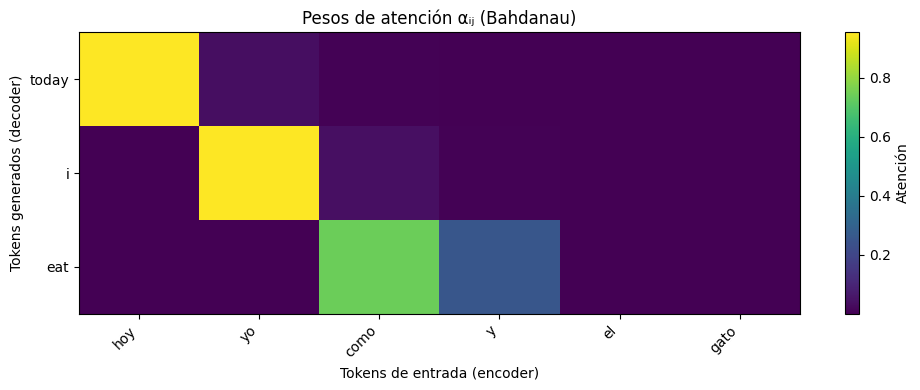

In [10]:
if attention_matrix is not None and attention_matrix.shape[0] > 0:
    plt.figure(figsize=(10, 4))
    plt.imshow(attention_matrix, aspect="auto")  # sin cmap explícito
    plt.xticks(
        ticks=range(len(input_tokens)),
        labels=input_tokens,
        rotation=45,
        ha="right",
    )
    plt.yticks(
        ticks=range(len(output_tokens)),
        labels=output_tokens,
    )
    plt.xlabel("Tokens de entrada (encoder)")
    plt.ylabel("Tokens generados (decoder)")
    plt.title("Pesos de atención αᵢⱼ (Bahdanau)")
    plt.colorbar(label="Atención")
    plt.tight_layout()
    plt.show()
else:
    print("No hay matriz de atención para visualizar.")

## 11. Ejemplo completo de inferencia
En esta celda se ejecutan dos ejemplos completos de inferencia, uno por dirección (es-en y en-es), cargando el checkpoint correspondiente en cada caso.Ç

In [11]:
examples = [
    ("es-en", "yo estudio en casa"),
    ("en-es", "i study at home"),
]

for direction, sent in examples:
    path = f"seq2seq_bahdanau_{direction}.pt"
    model, src_vocab, trg_vocab, src_pad, sos, eos = load_checkpoint(path)

    out_toks, attn_mat, in_toks = translate_with_attention(
        model, src_vocab, trg_vocab, src_pad, sos, eos, sent
    )

    print("\n=== Example ===")
    print("Direction:", direction)
    print("Input :", sent)
    print("Output:", " ".join(out_toks))
    print("Attn shape:", attn_mat.shape)



=== Example ===
Direction: es-en
Input : yo estudio en casa
Output: i study at home
Attn shape: (4, 4)

=== Example ===
Direction: en-es
Input : i study at home
Output: yo estudio en casa
Attn shape: (4, 4)
